# Global mass and energy conservations in CREDIT

In [11]:
# system
import os
import sys
import logging
from glob import glob
from typing import Dict
import xarray as xr

# others
import yaml
import numpy as np

# torch
import torch
from torch import nn
from torchvision import transforms as tforms

# credit
from credit.data import (
    Sample,
    concat_and_reshape,
    reshape_only,
    ERA5_and_Forcing_Dataset,
    get_forward_data
)

from credit.transforms import (
    Normalize_ERA5_and_Forcing,
    ToTensor_ERA5_and_Forcing,
    load_transforms
)

from credit.parser import (
    credit_main_parser,
    training_data_check
)

from credit.physics_core import physics_hybrid_sigma_level

from credit.physics_constants import (RAD_EARTH, GRAVITY, 
                                      RHO_WATER, LH_WATER, 
                                      RVGAS, RDGAS, CP_DRY, CP_VAPOR)

from credit.postblock import (
    PostBlock,
    SKEBS,
    TracerFixer,
    GlobalMassFixer,
    GlobalWaterFixer,
    GlobalEnergyFixer
)

# Core Layer to do Integrals and such

In [96]:
class physics_hybrid_sigma_level_here:
    '''
    Hybrid sigma-pressure level physics

    Attributes:
        lon (torch.Tensor): Longitude in degrees.
        lat (torch.Tensor): Latitude in degrees.
        surface_pressure (torch.Tensor): Surface pressure in Pa.
        coef_a (torch.Tensor): Hybrid sigma-pressure coefficient 'a' [Pa].
        coef_b (torch.Tensor): Hybrid sigma-pressure coefficient 'b' [unitless].
        area (torch.Tensor): Area of grid cells [m^2].
        integral (function): Vertical integration method (midpoint or trapezoidal).
    '''

    def __init__(self,
                 lon: torch.Tensor,
                 lat: torch.Tensor,
                 coef_a: torch.Tensor,
                 coef_b: torch.Tensor,
                 midpoint: bool = False):
        '''
        Initialize the class with longitude, latitude, and hybrid sigma-pressure levels.
        All inputs must be on the same torch device.
        Full order of dimensions: (batch, level, time, latitude, longitude)
        Accepted dimensions: (batch, level, latitude, longitude)
        
        Args:
            lon (torch.Tensor): Longitude in degrees.
            lat (torch.Tensor): Latitude in degrees.
            coef_a (torch.Tensor): Hybrid sigma-pressure coefficient 'a' [Pa] (level,).
            coef_b (torch.Tensor): Hybrid sigma-pressure coefficient 'b' [unitless] (level,).
            midpoint (bool): True if vertical level quantities are midpoint values; otherwise False.

        Note:
            pressure = coef_a + coef_b * surface_pressure
        '''
        self.lon = lon.to(torch.float64)
        self.lat = lat.to(torch.float64)
        self.coef_a = coef_a.to(torch.float64)  # (level,)
        self.coef_b = coef_b.to(torch.float64)  # (level,)

        # ========================================================================= #
        # Compute pressure on each hybrid sigma level
        # Reshape coef_a and coef_b for broadcasting
        self.coef_a = coef_a.view(1, -1, 1, 1)  # (1, level, 1, 1)
        self.coef_b = coef_b.view(1, -1, 1, 1)  # (1, level, 1, 1)
        
        # ========================================================================= #
        # compute gtid area
        # area = R^2 * d_sin(lat) * d_lon
        lat_rad = torch.deg2rad(self.lat).to(torch.float64)
        lon_rad = torch.deg2rad(self.lon).to(torch.float64)
        sin_lat_rad = torch.sin(lat_rad)
        d_phi = torch.gradient(sin_lat_rad, dim=0, edge_order=2)[0].to(torch.float64)
        d_lambda = torch.gradient(lon_rad, dim=1, edge_order=2)[0].to(torch.float64)
        d_lambda = (d_lambda + torch.pi) % (2 * torch.pi) - torch.pi
        self.area = torch.abs(RAD_EARTH**2 * d_phi * d_lambda).to(torch.float64)

        # ========================================================================== #
        # Vertical integration method
        if midpoint:
            self.integral = self.pressure_integral_midpoint
            self.integral_sliced = self.pressure_integral_midpoint_sliced
        else:
            self.integral = self.pressure_integral_trapz
            self.integral_sliced = self.pressure_integral_trapz_sliced

    def pressure_integral_midpoint(self, 
                                   q_mid: torch.Tensor,
                                   surface_pressure: torch.Tensor,) -> torch.Tensor:
        '''
        Compute the pressure level integral of a given quantity; assuming its mid-point
        values are pre-computed.

        Args:
            q_mid: The quantity with dims of (batch, level-1, time, latitude, longitude)
            surface_pressure: Surface pressure in Pa (batch, time, latitude, longitude).

        Returns:
            Pressure level integrals of q
        '''
        # (batch, 1, lat, lon)
        surface_pressure = surface_pressure.to(torch.float64).unsqueeze(1)

        # (batch, level, lat, lon)
        pressure = self.coef_a.to(q_mid.device) + self.coef_b.to(q_mid.device) * surface_pressure

        # (batch, level-1, lat, lon)
        delta_p = pressure.diff(dim=1).to(q_mid.device).to(torch.float64)

        # Element-wise multiplication
        q_area = q_mid.to(torch.float64) * delta_p

        # Sum over level dimension
        q_integral = torch.sum(q_area.to(torch.float64), dim=1)
        
        return q_integral
        
    def pressure_integral_midpoint_sliced(self,
                                          q_mid: torch.Tensor,
                                          surface_pressure: torch.Tensor,
                                          ind_start: int,
                                          ind_end: int) -> torch.Tensor:
        '''
        As in `pressure_integral_midpoint`, but supports pressure level indexing,
        so it can calculate integrals of a subset of levels.
        '''
        # (batch, 1, lat, lon)
        surface_pressure = surface_pressure.unsqueeze(1)

        # (batch, level, lat, lon)
        pressure = self.coef_a.to(q_mid.device) + self.coef_b.to(q_mid.device) * surface_pressure

        # (batch, level-1, lat, lon)
        pressure_thickness = pressure.diff(dim=1)
        
        delta_p = pressure_thickness[:, ind_start:ind_end, ...].to(q_mid.device)
        
        q_mid_sliced = q_mid[:, ind_start:ind_end, ...]
        q_area = q_mid_sliced * delta_p
        q_integral = torch.sum(q_area, dim=1)
        return q_integral

    def pressure_integral_trapz(self, 
                                q: torch.Tensor,
                                surface_pressure: torch.Tensor) -> torch.Tensor:
        '''
        Compute the pressure level integral of a given quantity using the trapezoidal rule.

        Args:
            q: The quantity with dims of (batch, level, time, latitude, longitude)

        Returns:
            Pressure level integrals of q
        '''
        # (batch, 1, lat, lon)
        surface_pressure = surface_pressure.unsqueeze(1)

        # (batch, level, lat, lon)
        pressure = self.coef_a.to(q.device) + self.coef_b.to(q.device) * surface_pressure

        # (batch, level-1, lat, lon)
        delta_p = pressure.diff(dim=1).to(q.device)

        # trapz
        q1 = q[:, :-1, ...]
        q2 = q[:, 1:, ...]
        q_area = 0.5 * (q1 + q2) * delta_p
        q_trapz = torch.sum(q_area, dim=1)
        
        return q_trapz

    def pressure_integral_trapz_sliced(self,
                                       q: torch.Tensor,
                                       surface_pressure: torch.Tensor,
                                       ind_start: int,
                                       ind_end: int) -> torch.Tensor:
        '''
        As in `pressure_integral_trapz`, but supports pressure level indexing,
        so it can calculate integrals of a subset of levels.
        '''
        # (batch, 1, lat, lon)
        surface_pressure = surface_pressure.unsqueeze(1)

        # (batch, level, lat, lon)
        pressure = self.coef_a.to(q.device) + self.coef_b.to(q.device) * surface_pressure
        
        delta_p = pressure[:, ind_start:ind_end, ...].diff(dim=1).to(q.device)

        # trapz
        q_slice = q[:, ind_start:ind_end, ...]
        q1 = q_slice[:, :-1, ...]
        q2 = q_slice[:, 1:, ...]
        q_area = 0.5 * (q1 + q2) * delta_p
        q_trapz = torch.sum(q_area, dim=1)
        
        return q_trapz

    def weighted_sum(self,
                     q: torch.Tensor,
                     axis: Dict[tuple, None] = None, 
                     keepdims: bool = False) -> torch.Tensor:
        '''
        Compute the weighted sum of a given quantity for PyTorch tensors.
        
        Args:
            data: the quantity to be summed (PyTorch tensor)
            axis: dims to compute the sum (can be int or tuple of ints)
            keepdims: whether to keep the reduced dimensions or not
    
        Returns:
            Weighted sum (PyTorch tensor)
        '''
        q_w = q.to(torch.float64) * self.area.to(torch.float64).to(q.device)
        q_sum = torch.sum(q_w, dim=axis, keepdim=keepdims)
        return q_sum

    def total_dry_air_mass(self, 
                           q: torch.Tensor,
                           surface_pressure: torch.Tensor) -> torch.Tensor:
        '''
        Compute the total mass of dry air over the entire globe [kg]
        '''
        mass_dry_per_area = self.integral(1-q.to(torch.float64), surface_pressure.to(torch.float64)) / GRAVITY # kg/m^2
        # weighted sum on latitude and longitude dimensions
        mass_dry_sum = self.weighted_sum(mass_dry_per_area, axis=(-2, -1)) # kg
        
        return mass_dry_sum

    def total_column_water(self, 
                           q: torch.Tensor,
                           surface_pressure: torch.Tensor,) -> torch.Tensor:
        '''
        Compute total column water (TCW) per air column [kg/m2]
        '''
        TWC = self.integral(q, surface_pressure) / GRAVITY # kg/m^2
        
        return TWC


def concat_fix(y_pred, q_pred_correct, q_ind_start, q_ind_end, N_vars):
    """
    this function use torch.concat to replace a specific subset of variable channels in `y_pred`.

    Given `q_pred = y_pred[:, ind_start:ind_end, ...]`, and `q_pred_correct` this function
    does: `y_pred[:, ind_start:ind_end, ...] = q_pred_correct`, but without using in-place
    modifications, so the graph of y_pred is maintained. It also handles
    `q_ind_start == q_ind_end cases`.

    All input tensors must have 5 dims of `batch, level-or-var, time, lat, lon`

    Args:
        y_pred (torch.Tensor): Original y_pred tensor of shape (batch, var, time, lat, lon).
        q_pred_correct (torch.Tensor): Corrected q_pred tensor.
        q_ind_start (int): Index where q_pred starts in y_pred.
        q_ind_end (int): Index where q_pred ends in y_pred.
        N_vars (int): Total number of variables in y_pred (i.e., y_pred.shape[1]).

    Returns:
        torch.Tensor: Concatenated y_pred with corrected q_pred.
    """
    # define a list that collects tensors
    var_list = []

    # vars before q_pred
    if q_ind_start > 0:
        var_list.append(y_pred[:, :q_ind_start, ...])

    # q_pred
    var_list.append(q_pred_correct)

    # vars after q_pred
    if q_ind_end < N_vars - 1:
        if q_ind_start == q_ind_end:
            var_list.append(y_pred[:, q_ind_end + 1 :, ...])
        else:
            var_list.append(y_pred[:, q_ind_end:, ...])

    return torch.cat(var_list, dim=1)


class TracerFixer_here(nn.Module):
    """
    This module fixes tracer values by replacing their values to a given threshold
    (e.g., `tracer[tracer<thres] = thres`).

    Args:
        post_conf (dict): config dictionary that includes all specs for the tracer fixer.
    """

    def __init__(self, post_conf):
        super().__init__()

        # ------------------------------------------------------------------------------ #
        # identify variables of interest
        self.tracer_indices = post_conf["tracer_fixer"]["tracer_inds"]
        self.tracer_thres = post_conf["tracer_fixer"]["tracer_thres"]

        print('tracer inds:', self.tracer_indices, 'len:', len(self.tracer_indices))

        # ------------------------------------------------------------------------------ #
        # setup a scaler
        if post_conf["tracer_fixer"]["denorm"]:
            self.state_trans = load_transforms(post_conf, scaler_only=True)
        else:
            self.state_trans = None

    def forward(self, x):
        # ------------------------------------------------------------------------------ #
        # get y_pred
        # y_pred is channel first: (batch, var, time, lat, lon)
        y_pred = x["y_pred"]

        # if denorm is needed
        if self.state_trans:
            y_pred = self.state_trans.inverse_transform(y_pred)

        # ------------------------------------------------------------------------------ #
        # tracer correction
        for i, i_var in enumerate(self.tracer_indices):
            # get the tracers
            tracer_vals = y_pred[:, i_var, ...]

            # in-place modification of y_pred
            thres = self.tracer_thres[i]
            tracer_vals[tracer_vals < thres] = thres

        if self.state_trans:
            y_pred = self.state_trans.transform_array(y_pred)

        # give it back to x
        x["y_pred"] = y_pred

        # return dict, 'x' is not touched
        return x

# Look at Each Post- Block method - check for zero residual. 

In [13]:
# plot
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
# Logging setup
logger = logging.getLogger(__name__)

# single node steup
rank = 0
world_size = 1

# Load yaml

In [15]:
# old rollout config
config_name = './model_QTOT.yml'
# Read YAML file
with open(config_name, 'r') as stream:
    conf = yaml.safe_load(stream)
conf = credit_main_parser(conf, parse_training=True, parse_predict=False, print_summary=False)

## Data workflow

### Gather data information

In [134]:
# pick a year
train_years_range = [1991, 1993]
valid_years_range = [1991, 1993]

In [135]:
all_ERA_files = sorted(glob(conf["data"]["save_loc"]))

# check and glob surface files
if ('surface_variables' in conf['data']) and (len(conf['data']['surface_variables']) > 0):
    surface_files = sorted(glob(conf["data"]["save_loc_surface"]))

else:
    surface_files = None

# check and glob dyn forcing files
if ('dynamic_forcing_variables' in conf['data']) and (len(conf['data']['dynamic_forcing_variables']) > 0):
    dyn_forcing_files = sorted(glob(conf["data"]["save_loc_dynamic_forcing"]))

else:
    dyn_forcing_files = None

# check and glob diagnostic files
if ('diagnostic_variables' in conf['data']) and (len(conf['data']['diagnostic_variables']) > 0):
    diagnostic_files = sorted(glob(conf["data"]["save_loc_diagnostic"]))

else:
    diagnostic_files = None

# convert year info to str for file name search
train_years = [str(year) for year in range(train_years_range[0], train_years_range[1])]
valid_years = [str(year) for year in range(valid_years_range[0], valid_years_range[1])]

# Filter the files for training / validation
train_files = [file for file in all_ERA_files if any(year in file for year in train_years)]
valid_files = [file for file in all_ERA_files if any(year in file for year in valid_years)]

if surface_files is not None:

    train_surface_files = [file for file in surface_files if any(year in file for year in train_years)]
    valid_surface_files = [file for file in surface_files if any(year in file for year in valid_years)]
    
else:
    train_surface_files = None
    valid_surface_files = None

if dyn_forcing_files is not None:

    train_dyn_forcing_files = [file for file in dyn_forcing_files if any(year in file for year in train_years)]
    valid_dyn_forcing_files = [file for file in dyn_forcing_files if any(year in file for year in valid_years)]

else:
    train_dyn_forcing_files = None
    valid_dyn_forcing_files = None

if diagnostic_files is not None:

    train_diagnostic_files = [file for file in diagnostic_files if any(year in file for year in train_years)]
    valid_diagnostic_files = [file for file in diagnostic_files if any(year in file for year in valid_years)]

else:
    train_diagnostic_files = None
    valid_diagnostic_files = None

# --------------------------------------------------- #
is_train = False
# separate training set and validation set cases
if is_train:
    history_len = conf["data"]["history_len"]
    forecast_len = conf["data"]["forecast_len"]
    name = "training"
else:
    history_len = conf["data"]["valid_history_len"]
    forecast_len = conf["data"]["valid_forecast_len"]
    name = 'validation'

# Dataset

/glade/work/wchapman/conda-envs/credit-dk-casper/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/glade/work/wchapman/conda-envs/credit-dk-casper/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


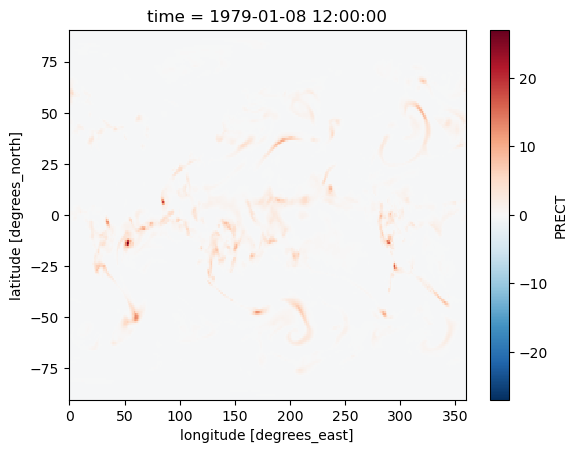

In [136]:
# # transforms
transforms = load_transforms(conf)

if conf['data']['sst_forcing']['activate']:
    sst_forcing = {'varname_skt': conf['data']['sst_forcing']['varname_skt'], 
                   'varname_ocean_mask': conf['data']['sst_forcing']['varname_ocean_mask']}
else:
    sst_forcing = None

# Z-score
dataset = ERA5_and_Forcing_Dataset(
    varname_upper_air=conf['data']['variables'],
    varname_surface=conf['data']['surface_variables'],
    varname_dyn_forcing=conf['data']['dynamic_forcing_variables'],
    varname_forcing=conf['data']['forcing_variables'],
    varname_static=conf['data']['static_variables'],
    varname_diagnostic=conf['data']['diagnostic_variables'],
    filenames=train_files,
    filename_surface=train_surface_files,
    filename_dyn_forcing=train_dyn_forcing_files,
    filename_forcing=conf['data']['save_loc_forcing'],
    filename_static=conf['data']['save_loc_static'],
    filename_diagnostic=train_diagnostic_files,
    history_len=history_len,
    forecast_len=forecast_len,
    skip_periods=conf["data"]["skip_periods"],
    one_shot=conf['data']['one_shot'],
    max_forecast_len=conf["data"]["max_forecast_len"],
    transform=transforms,
    sst_forcing=sst_forcing
)

# # sampler
# sampler = DistributedSampler(
#     dataset,
#     num_replicas=world_size,
#     rank=rank,
#     seed=seed,
#     shuffle=is_train,
#     drop_last=True
# )

varvar = 'PRECT'
dsm = xr.open_dataset('/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/mean_6h_1979_2010_32lev_1.0deg_ERA5scaled_F32_Qtot.nc')
dss = xr.open_dataset('/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/std_6h_1979_2010_32lev_1.0deg_ERA5scaled_F32_Qtot.nc')

DScesm = xr.open_dataset('/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate_1979_ERA5scaled_F32_Qtot.zarr')
((DScesm[varvar].isel(time=30)-dsm[varvar].values)/dss[varvar].values).plot()
plt.show()

# Grab an example training batch

In [137]:
batch_single = dataset.__getitem__(1001)
batch = {}
keys = list(batch_single.keys())
keys = keys[:-1]
for var in keys:
    batch[var] = batch_single[var].unsqueeze(0) # give a single sample batch dimension

# ------------------------- #
# base trainer workflow

if "x_surf" in batch:
    # combine x and x_surf
    # input: (batch_num, time, var, level, lat, lon), (batch_num, time, var, lat, lon)
    # output: (batch_num, var, time, lat, lon), 'x' first and then 'x_surf'
    x = concat_and_reshape(batch["x"], batch["x_surf"])
else:
    # no x_surf
    x = reshape_only(batch["x"]).to(self.device).float()

# --------------------------------------------------------------------------------- #
# add forcing and static variables
if 'x_forcing_static' in batch:

    # (batch_num, time, var, lat, lon) --> (batch_num, var, time, lat, lon)
    x_forcing_batch = batch['x_forcing_static'].permute(0, 2, 1, 3, 4)

    # concat on var dimension
    x = torch.cat((x, x_forcing_batch), dim=1)

# --------------------------------------------------------------------------------- #
# combine y and y_surf
if "y_surf" in batch:
    y = concat_and_reshape(batch["y"], batch["y_surf"])
else:
    y = reshape_only(batch["y"])

if 'y_diag' in batch:

    # (batch_num, time, var, lat, lon) --> (batch_num, var, time, lat, lon)
    y_diag_batch = batch['y_diag'].permute(0, 2, 1, 3, 4).float()

    # concat on var dimension
    y = torch.cat((y, y_diag_batch), dim=1)
x = x.to(torch.float64)
y = y.to(torch.float64)

print('you now have a y and x and clones to keep the originals hanging around')
y_original = y.clone()
x_original = x.clone()

#get the post conf 
post_conf = conf['model']['post_conf']
state_trans = load_transforms(post_conf, scaler_only=True)
print('the post config file is loaded along with the transforms')


you now have a y and x and clones to keep the originals hanging around
the post config file is loaded along with the transforms


## `credit.postblock` tests

### `physics_hybrid_sigma_level`

In [573]:
print('first look at a zarr file and ensure they are float 32 values')
DS_one_zarr_year = xr.open_zarr('/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate_2000_ERA5scaled_F32_Qtot.zarr')
DS_one_zarr_year
print('they are all float32 values')
DS_one_zarr_year

first look at a zarr file and ensure they are float 32 values
they are all float32 values


<xarray.Dataset> Size: 92GB
Dimensions:    (time: 1460, latitude: 192, longitude: 288, level: 32, ilev: 33)
Coordinates:
  * ilev       (ilev) float32 132B 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * latitude   (latitude) float32 768B -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * level      (level) float32 128B 3.643 7.595 14.36 ... 957.5 976.3 992.6
  * longitude  (longitude) float32 1kB 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
  * time       (time) object 12kB 2000-01-01 00:00:00 ... 2000-12-31 18:00:00
Data variables: (12/43)
    CLDHGH     (time, latitude, longitude) float32 323MB dask.array<chunksize=(4, 192, 288), meta=np.ndarray>
    CLDLOW     (time, latitude, longitude) float32 323MB dask.array<chunksize=(4, 192, 288), meta=np.ndarray>
    CLDMED     (time, latitude, longitude) float32 323MB dask.array<chunksize=(4, 192, 288), meta=np.ndarray>
    CLDTOT     (time, latitude, longitude) float32 323MB dask.array<chunksize=(4, 192, 288), meta=np.ndarray>
    FLDS       (time, latitude, longitude) float32 323MB dask.array<chunksize=(4, 192, 288), meta=np.ndarray>
    FLNS       (time, latitude, longitude) float32 323MB dask.array<chunksize=(4, 192, 288), meta=np.ndarray>
    ...         ...
    V          (time, level, latitude, longitude) float32 10GB dask.array<chunksize=(4, 32, 192, 288), meta=np.ndarray>
    ZMMU       (time, level, latitude, longitude) float32 10GB dask.array<chunksize=(4, 32, 192, 288), meta=np.ndarray>
    hyai       (time, ilev) float32 193kB dask.array<chunksize=(4, 33), meta=np.ndarray>
    hyam       (time, level) float32 187kB dask.array<chunksize=(4, 32), meta=np.ndarray>
    hybi       (time, ilev) float32 193kB dask.array<chunksize=(4, 33), meta=np.ndarray>
    hybm       (time, level) float32 187kB dask.array<chunksize=(4, 32), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0
    case:              f.e21.CREDIT_climate
    host:              derecho7
    initial_file:      f.e20.FHIST.f09_f09.cesm2_1.001_v2.cam.i.1979-01-01-00...
    logname:           wchapman
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    source:            CAM
    time_period_freq:  hour_6
    topography_file:   /glade/campaign/cesm/cesmdata/inputdata/atm/cam/topo/f...

## Tracer Fixer

In [574]:
opt = TracerFixer_here(post_conf)
input_dict = {"y_pred": y, "x": x,}
post_conf = conf['model']['post_conf']
opt = TracerFixer(post_conf)

tracer inds: [96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 131, 132, 133, 134, 135, 138] len: 38


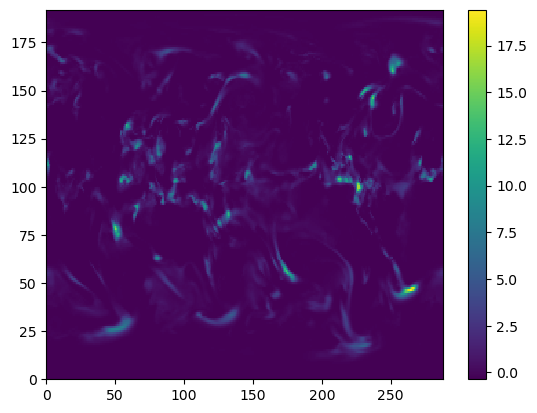

In [575]:
for i in range(1):
    input_dict = opt(input_dict)
    
y_pred = input_dict['y_pred']
plt.pcolor(y_pred[0,131,0,:,:])
plt.colorbar()
plt.show()

# Global dry mass fixer

In [139]:
batch_single = dataset.__getitem__(15)
batch = {}
keys = list(batch_single.keys())
keys = keys[:-1]
for var in keys:
    batch[var] = batch_single[var].unsqueeze(0) # give a single sample batch dimension

# ------------------------- #
# base trainer workflow

if "x_surf" in batch:
    # combine x and x_surf
    # input: (batch_num, time, var, level, lat, lon), (batch_num, time, var, lat, lon)
    # output: (batch_num, var, time, lat, lon), 'x' first and then 'x_surf'
    x = concat_and_reshape(batch["x"], batch["x_surf"])
else:
    # no x_surf
    x = reshape_only(batch["x"]).to(self.device).float()

# --------------------------------------------------------------------------------- #
# add forcing and static variables
if 'x_forcing_static' in batch:

    # (batch_num, time, var, lat, lon) --> (batch_num, var, time, lat, lon)
    x_forcing_batch = batch['x_forcing_static'].permute(0, 2, 1, 3, 4)

    # concat on var dimension
    x = torch.cat((x, x_forcing_batch), dim=1)

# --------------------------------------------------------------------------------- #
# combine y and y_surf
if "y_surf" in batch:
    y = concat_and_reshape(batch["y"], batch["y_surf"])
else:
    y = reshape_only(batch["y"])

if 'y_diag' in batch:

    # (batch_num, time, var, lat, lon) --> (batch_num, var, time, lat, lon)
    y_diag_batch = batch['y_diag'].permute(0, 2, 1, 3, 4).float()

    # concat on var dimension
    y = torch.cat((y, y_diag_batch), dim=1)

x = x.to(torch.float64)
y = y.to(torch.float64)
print('you now have a y and x and clones to keep the originals hanging around')
y_original = y.clone()
x_original = x.clone()

#get the post conf 
post_conf = conf['model']['post_conf']
state_trans = load_transforms(post_conf, scaler_only=True)
print('the post config file is loaded along with the transforms')


you now have a y and x and clones to keep the originals hanging around
the post config file is loaded along with the transforms
tensor(-0.4467, dtype=torch.float64)


In [738]:
RHO_WATER = torch.tensor(1000.0).to(torch.float64)
GRAVITY = torch.tensor(9.80665).to(torch.float64)

class GlobalDryMassFixer_here(nn.Module):
    '''
    This module applies global dry mass conservation fixes for the dry mass budget.
    The output ensures that the global dry air mass is conserved through correction ratios 
    applied during model runs. Variables `SP` (surface pressure) will be corrected to close the budget.
    All corrections are done using float32 PyTorch tensors.
    
    Args:
        post_conf (dict): config dictionary that includes all specs for the global dry mass fixer.
    '''
    
    def __init__(self, post_conf):
        super().__init__()

        # ------------------------------------------------------------------------------------ #
        # initialize physics computation
        print('DOING just DRY MASSS taco')
        # provide example data if it is a unit test
        if post_conf['global_drymass_fixer']['simple_demo']:
            y_demo = np.array([90, 70, 50, 30, 10, -10, -30, -50, -70, -90])
            x_demo = np.array([0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 
                               200, 220, 240, 260, 280, 300, 320, 340])
            
            lon_demo, lat_demo = np.meshgrid(x_demo, y_demo)
            lon_demo = torch.from_numpy(lon_demo)
            lat_demo = torch.from_numpy(lat_demo)

            p_level_demo = torch.from_numpy(np.array([100, 30000, 50000, 70000, 80000, 90000, 100000]))
            self.flag_sigma_level = False
            self.flag_midpoint = post_conf['global_drymass_fixer']['midpoint']
            self.core_compute = physics_pressure_level_here(lon_demo, lat_demo, p_level_demo, 
                                                       midpoint=self.flag_midpoint)
            self.N_levels = len(p_level_demo)
            self.ind_fix = len(p_level_demo) - int(post_conf['global_drymass_fixer']['fix_level_num']) + 1
            self.requires_scaling = False
            
        else:
            # the actual setup for model runs
            ds_physics = get_forward_data(post_conf['data']['save_loc_physics'])
            
            lon_lat_level_names = post_conf['global_drymass_fixer']['lon_lat_level_name']
            lon2d = torch.from_numpy(ds_physics[lon_lat_level_names[0]].values).to(torch.float64)
            lat2d = torch.from_numpy(ds_physics[lon_lat_level_names[1]].values).to(torch.float64)
            
            # -------------------------------------------------------------------------- #
            # pick physics core
            self.flag_midpoint = post_conf['global_drymass_fixer']['midpoint']
            
            if post_conf['global_drymass_fixer']['grid_type'] == 'sigma':
                self.flag_sigma_level = True
                self.coef_a = torch.from_numpy(ds_physics[lon_lat_level_names[2]].values).to(torch.float64)
                self.coef_b = torch.from_numpy(ds_physics[lon_lat_level_names[3]].values).to(torch.float64)
                
                # get total number of levels
                self.N_levels = len(self.coef_a)
                if self.flag_midpoint:
                    self.N_levels = self.N_levels -1
                    
                self.core_compute = physics_hybrid_sigma_level_here(lon2d.to(torch.float64), 
                                                               lat2d.to(torch.float64), 
                                                               self.coef_a.to(torch.float64), 
                                                               self.coef_b.to(torch.float64), 
                                                               midpoint=self.flag_midpoint)
            else:
                self.flag_sigma_level = False        
                p_level = torch.from_numpy(ds_physics[lon_lat_level_names[2]].values).float()
                # get total number of levels
                self.N_levels = len(p_level)
                
                self.core_compute = physics_pressure_level(lon2d, 
                                                           lat2d, 
                                                           p_level, 
                                                           midpoint=self.flag_midpoint)

            self.requires_scaling = post_conf['requires_scaling']
            # -------------------------------------------------------------------------- #
            self.ind_fix = self.N_levels - int(post_conf['global_drymass_fixer']['fix_level_num']) + 1

        # -------------------------------------------------------------------------- #
        if self.flag_midpoint:
            self.ind_fix_start = self.ind_fix
        else:
            self.ind_fix_start = self.ind_fix-1
            
        # ------------------------------------------------------------------------------------ #
        # identify variables of interest
        self.q_ind_start = int(post_conf['global_drymass_fixer']['q_inds'][0])
        self.q_ind_end = int(post_conf['global_drymass_fixer']['q_inds'][-1]) + 1
        if self.flag_sigma_level:
            self.sp_ind = int(post_conf['global_drymass_fixer']['sp_inds'])
        # ------------------------------------------------------------------------------------ #
        # setup a scaler
        if post_conf['global_drymass_fixer']['denorm']:
            self.state_trans = load_transforms(post_conf, scaler_only=True)
        else:
            self.state_trans = None

        self.post_conf = post_conf
            
    def forward(self, x):
        # ------------------------------------------------------------------------------ #
        # get tensors

        # x_input (batch, var, time, lat, lon)
        x_input = x['x'].to(torch.float64)
        y_pred = x["y_pred"].to(torch.float64)

        # detach x_input
        x_input = x_input.detach().to(y_pred.device).to(torch.float64)

        # other needed inputs
        N_vars = y_pred.shape[1]
        
        # if denorm is needed
        if self.state_trans:
            print('state trans 1')
            x_input = self.state_trans.inverse_transform_input(x_input.to(torch.float64)).to(torch.float64)
            y_pred = self.state_trans.inverse_transform(y_pred.to(torch.float64)).to(torch.float64)

        # y_pred (batch, var, time, lat, lon) 
        # pick the first time-step, y_pred is expected to have the next step only
        # !!! Note: time dimension is collapsed throughout !!!
        
        q_input = x_input[:, self.q_ind_start:self.q_ind_end, -1, ...].to(torch.float64)
        q_pred = y_pred[:, self.q_ind_start:self.q_ind_end, 0, ...].to(torch.float64)

        if self.flag_sigma_level:
            sp_input = x_input[:, self.sp_ind, -1, ...].to(torch.float64)
            sp_pred = y_pred[:, self.sp_ind, 0, ...].to(torch.float64)

        if self.requires_scaling:
            #print('scaling coef Q: ',self.post_conf['scaling_coefs']['Q'])
            q_input = q_input*self.post_conf['scaling_coefs']['Q'].to(torch.float64)
            q_pred = q_pred*self.post_conf['scaling_coefs']['Q'].to(torch.float64)
            sp_input = sp_input*self.post_conf['scaling_coefs']['SP'].to(torch.float64)
            sp_pred = sp_pred*self.post_conf['scaling_coefs']['SP'].to(torch.float64)
        # ------------------------------------------------------------------------------ #
        # global dry air mass conservation
        # ------------------------------------------------------------------------------ #
        print('GRAV', GRAVITY.dtype)
        if self.flag_sigma_level:
            print('hey hey', GRAVITY.dtype)
            # total dry air mass from q_input
            print('q_input', (1-q_input).shape)
            print('sp_input' ,sp_input.shape)
            mass_dry_sum_t0 = self.core_compute.total_dry_air_mass(q_input.to(torch.float64), sp_input.to(torch.float64)).to(torch.float64)
            
            # total mass from q_pred
            mass_dry_sum_t1_hold = self.core_compute.weighted_sum(
                self.core_compute.integral_sliced(1-q_pred, sp_pred, 0, self.ind_fix).to(torch.float64) / GRAVITY, 
                axis=(-2, -1)).to(torch.float64)

            print('1-q_pred', (1-q_pred).shape)
            print('sp_pred' ,sp_pred.shape)
           
        else:
            # total dry air mass from q_input
            mass_dry_sum_t0 = self.core_compute.total_dry_air_mass(q_input)
        
            # total mass from q_pred
            mass_dry_sum_t1_hold = self.core_compute.weighted_sum(
                self.core_compute.integral_sliced(1-q_pred, 0, self.ind_fix) / GRAVITY, 
                axis=(-2, -1))
            
        # ===================================================================== #
        # surface pressure fixes on global dry air mass conservation
        # model level only
        
        if self.flag_sigma_level:
            #print('in GlobalDryMassFixer flag sigma level')
            delta_coef_a = self.coef_a.diff().to(q_pred.device).to(torch.float64)
            delta_coef_b = self.coef_b.diff().to(q_pred.device).to(torch.float64)

            print('delta_coef_b.shape', delta_coef_b.shape)
            print('delta_coef_a.shape', delta_coef_a.shape)
            print('(1 - q_pred).shape:', (1 - q_pred).shape)
            
            if self.flag_midpoint:
                #print('in flag midpoint Dry')
                p_dry_a = ((delta_coef_a.unsqueeze(0).unsqueeze(2).unsqueeze(3)) * (1 - q_pred)).sum(1)
                p_dry_b = ((delta_coef_b.unsqueeze(0).unsqueeze(2).unsqueeze(3)) * (1 - q_pred)).sum(1)
            else:
                q_mid = (q_pred[:, :-1, ...] + q_pred[:, 1:, ...]) / 2
                p_dry_a = ((delta_coef_a.unsqueeze(0).unsqueeze(2).unsqueeze(3)) * (1 - q_mid)).sum(1)
                p_dry_b = ((delta_coef_b.unsqueeze(0).unsqueeze(2).unsqueeze(3)) * (1 - q_mid)).sum(1)

            print('p_dry_a.shape',p_dry_a.shape)

            grid_area = self.core_compute.area.unsqueeze(0).to(q_pred.device).to(torch.float64)

            print('shape of calc', ((p_dry_a * grid_area).shape))
            
            mass_dry_a = (p_dry_a * grid_area).sum((-2, -1)) / GRAVITY
            mass_dry_b = (p_dry_b * sp_pred * grid_area).sum((-2, -1)) / GRAVITY

            print('GRAVITY dtype', ((p_dry_a * grid_area).shape))
            
            # sp correction ratio using t0 dry air mass and t1 moisture
            print('mass_dry_sum_t0 dtype:', mass_dry_sum_t0.dtype)
            print('mass_dry_a dtype:', mass_dry_a.dtype)
            print(' mass_dry_b dtype:',  mass_dry_b.dtype)
            print('mass_dry_sum_t0 total:', mass_dry_sum_t0)
            print('mass_dry_a total:', mass_dry_a)
            print(' mass_dry_b total:',  mass_dry_b)

            
            sp_correct_ratio = (mass_dry_sum_t0 - mass_dry_a) / mass_dry_b
            
            print('sp_correct_ratio:', sp_correct_ratio)
            print('sp_correct_ratio dtype:', sp_correct_ratio.dtype)
            print('sp_pred dtype:', sp_pred.dtype)
            sp_correct_ratio = sp_correct_ratio.unsqueeze(1).unsqueeze(2)
            sp_pred = sp_pred * sp_correct_ratio

            # Set the print options to display full precision
            torch.set_printoptions(precision=45, sci_mode=False)
            print('!!!! sp_correct_ratio dry !!!!', sp_correct_ratio)

            # expand fixed vars to (batch, level, time, lat, lon)
            sp_pred = sp_pred.unsqueeze(1).unsqueeze(2)

            print('1-q_pred', (1-q_pred).shape)
            print('sp_pred' ,sp_pred.shape)

            # mass_dry_sum_t0 = self.core_compute.total_dry_air_mass(q_input.to(torch.float64), sp_input.to(torch.float64)).to(torch.float64)
            mass_dry_sum_after = self.core_compute.total_dry_air_mass(q_pred.to(torch.float64), sp_pred[0,0,:,:,:].to(torch.float64)).to(torch.float64)

            print(f'{mass_dry_sum_t0} {mass_dry_sum_after} diff: {np.array(mass_dry_sum_t0 - mass_dry_sum_after)}')
            
            if self.requires_scaling:
                sp_input = sp_input/self.post_conf['scaling_coefs']['SP']
                sp_pred = sp_pred/self.post_conf['scaling_coefs']['SP']
            
            y_pred = concat_fix(y_pred, sp_pred, self.sp_ind, self.sp_ind, N_vars)
            
        # ===================================================================== #        
        if self.state_trans:
            print('hi')
            print(y_pred.dtype)
            y_pred = self.state_trans.transform_array(y_pred)
            print(y_pred.dtype)
        
        # give it back to x
        x["y_pred"] = y_pred

        # return dict, 'x' is not touched
        return x

In [739]:
#from credit.postblock import concat_fix

In [740]:
x = x.to(torch.float64)
y = y.to(torch.float64)

input_dict = {"y_pred": y.to(torch.float64), "x": x.to(torch.float64),}
post_conf = conf['model']['post_conf']
opt = GlobalDryMassFixer_here(post_conf)

DOING just DRY MASSS taco


In [741]:
for i in range(1):
    input_dict = opt(input_dict)
    
y_pred = input_dict['y_pred']
# plt.pcolor(y_pred[0,131,0,:,:])
# plt.colorbar()
# plt.show()

state trans 1
GRAV torch.float64
hey hey torch.float64
q_input torch.Size([1, 32, 192, 288])
sp_input torch.Size([1, 192, 288])
1-q_pred torch.Size([1, 32, 192, 288])
sp_pred torch.Size([1, 192, 288])
delta_coef_b.shape torch.Size([32])
delta_coef_a.shape torch.Size([32])
(1 - q_pred).shape: torch.Size([1, 32, 192, 288])
p_dry_a.shape torch.Size([1, 192, 288])
shape of calc torch.Size([1, 192, 288])
GRAVITY dtype torch.Size([1, 192, 288])
mass_dry_sum_t0 dtype: torch.float64
mass_dry_a dtype: torch.float64
 mass_dry_b dtype: torch.float64
mass_dry_sum_t0 total: tensor([                               5100053614945137664.])
mass_dry_a total: tensor([                                  -9184601869032110.])
 mass_dry_b total: tensor([                               5109240863210916864.])
sp_correct_ratio: tensor([0.999999482037191467220793583692284300923347473])
sp_correct_ratio dtype: torch.float64
sp_pred dtype: torch.float64
!!!! sp_correct_ratio dry !!!! tensor([[[0.9999994820371914672207

# **Check before & after**

In [744]:
def mass_residual_verif(x, y_pred):

    state_trans = load_transforms(post_conf, scaler_only=True)
    
    x = state_trans.inverse_transform_input(x.to(torch.float64))
    y_pred = state_trans.inverse_transform(y_pred.to(torch.float64))
    
    q_ind_start = opt.q_ind_start
    q_ind_end = opt.q_ind_end
    sp_ind = opt.sp_ind
    sp_input = x[:, sp_ind, -1, ...]
    sp_pred = y_pred[:, sp_ind, 0, ...]
    
    ds_physics = get_forward_data(post_conf['data']['save_loc_physics'])        
    lon2d = torch.from_numpy(ds_physics['lon2d'].values).to(torch.float64)
    lat2d = torch.from_numpy(ds_physics['lat2d'].values).to(torch.float64)
    coef_a = torch.from_numpy(ds_physics['hyai'].values).to(torch.float64)
    coef_b = torch.from_numpy(ds_physics['hybi'].values).to(torch.float64)
    
    core_compute = physics_hybrid_sigma_level_here(lon2d, lat2d, coef_a, coef_b, midpoint=True)
    
    mass_dry_sum_t0 = core_compute.total_dry_air_mass(x[:, q_ind_start:q_ind_end, -1, ...].to(torch.float64), sp_input.to(torch.float64))
    mass_dry_sum_t1 = core_compute.total_dry_air_mass(y_pred[:, q_ind_start:q_ind_end, 0, ...].to(torch.float64), sp_pred.to(torch.float64))
    mass_residual = mass_dry_sum_t1 - mass_dry_sum_t0

    # print(f"Residual [float64]: {np.array(mass_residual):.16e}")
    mass_residual_np = mass_residual.detach().cpu().numpy()
    print(mass_residual_np.dtype)
    
    print(f'Residual to conserve mass budget [kg]: {mass_residual}')
    print(f"Residual [float64]: {mass_residual_np[0]:.6f}")  # Format as float with 6 decimal places
    return mass_residual, mass_dry_sum_t1, mass_dry_sum_t0

In [764]:
print('======================== Before ==============================')
residual_, M_t1, M_t0 = mass_residual_verif(x_original, y_original)
print(f'Input state total air mass [kg]: {M_t0}')
print(f'Output state total air mass [kg]: {M_t1}')

print('======================== After ==============================')
residual_, M_t1, M_t0 = mass_residual_verif(x_original, y_pred)
print(f'Input state total air mass [kg]: {M_t0}')
print(f'Output state total air mass [kg]: {M_t1}')

print(f'SP largest modified amount: {np.abs(np.array(y_pred[0, sp_ind, ...].squeeze()-y_original[0, sp_ind, ...].squeeze())).max()}')

======================== Before ==============================
float64
Residual to conserve mass budget [kg]: tensor([                                     2646396746752.])
Residual [float64]: 2646396746752.000000
Input state total air mass [kg]: tensor([                               5100053614945137664.])
Output state total air mass [kg]: tensor([                               5100056261341884416.])
======================== After ==============================
float64
Residual to conserve mass budget [kg]: tensor([0.])
Residual [float64]: 0.000000
Input state total air mass [kg]: tensor([                               5100053614945137664.])
Output state total air mass [kg]: tensor([                               5100053614945137664.])
SP largest modified amount: 5.59242031150653e-06


# Global water fixer

In [457]:
class GlobalWaterFixer_here(nn.Module):
    
    def __init__(self, post_conf):
        super().__init__()
        torch.set_default_dtype(torch.float64)  # Use higher precision for all tensors
        # ------------------------------------------------------------------------------------ #
        # initialize physics computation

        # provide example data if it is a unit test
        if post_conf['global_water_fixer']['simple_demo']:
            y_demo = np.array([90, 70, 50, 30, 10, -10, -30, -50, -70, -90])
            x_demo = np.array([0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 
                               200, 220, 240, 260, 280, 300, 320, 340])
            
            lon_demo, lat_demo = np.meshgrid(x_demo, y_demo)
            lon_demo = torch.from_numpy(lon_demo)
            lat_demo = torch.from_numpy(lat_demo)

            p_level_demo = torch.from_numpy(np.array([100, 30000, 50000, 70000, 80000, 90000, 100000]))
            self.flag_sigma_level = False
            self.flag_midpoint = post_conf['global_water_fixer']['midpoint']
            self.core_compute = physics_pressure_level_here(lon_demo, lat_demo, p_level_demo, 
                                                       midpoint=self.flag_midpoint)
            self.N_levels = len(p_level_demo)
            self.N_seconds = int(post_conf['data']['lead_time_periods']) * 3600
            self.requires_scaling = False
            
        else:
            # the actual setup for model runs
            ds_physics = get_forward_data(post_conf['data']['save_loc_physics'])
            
            lon_lat_level_names = post_conf['global_mass_fixer']['lon_lat_level_name']
            lon2d = torch.from_numpy(ds_physics[lon_lat_level_names[0]].values).to(torch.float64)
            lat2d = torch.from_numpy(ds_physics[lon_lat_level_names[1]].values).to(torch.float64)
            
            # -------------------------------------------------------------------------- #
            # pick physics core
            self.flag_midpoint = post_conf['global_mass_fixer']['midpoint']
            
            if post_conf['global_mass_fixer']['grid_type'] == 'sigma':
                self.flag_sigma_level = True
                self.coef_a = torch.from_numpy(ds_physics[lon_lat_level_names[2]].values).to(torch.float64)
                self.coef_b = torch.from_numpy(ds_physics[lon_lat_level_names[3]].values).to(torch.float64)
                
                # get total number of levels
                self.N_levels = len(self.coef_a)
                
                if self.flag_midpoint:
                    self.N_levels = self.N_levels -1
                    
                self.core_compute = physics_hybrid_sigma_level_here(lon2d.to(torch.float64), 
                                                               lat2d.to(torch.float64), 
                                                               self.coef_a.to(torch.float64), 
                                                               self.coef_b.to(torch.float64), 
                                                               midpoint=self.flag_midpoint)
            else:
                self.flag_sigma_level = False        
                p_level = torch.from_numpy(ds_physics[lon_lat_level_names[2]].values).float()
                # get total number of levels
                self.N_levels = len(p_level)
                
                self.core_compute = physics_pressure_level(lon2d, 
                                                           lat2d, 
                                                           p_level, 
                                                           midpoint=self.flag_midpoint)

            self.requires_scaling = post_conf['requires_scaling']
            self.N_seconds = torch.tensor(int(post_conf['data']['lead_time_periods']) * 3600.).to(torch.float64)
            
        # ------------------------------------------------------------------------------------ #
        # identify variables of interest
        self.q_ind_start = int(post_conf['global_water_fixer']['q_inds'][0])
        self.q_ind_end = int(post_conf['global_water_fixer']['q_inds'][-1]) + 1
        self.precip_ind = int(post_conf['global_water_fixer']['precip_ind'])
        self.evapor_ind = int(post_conf['global_water_fixer']['evapor_ind'])
        if self.flag_sigma_level:
            self.sp_ind = int(post_conf['global_mass_fixer']['sp_inds'])            
        # ------------------------------------------------------------------------------------ #
        # setup a scaler
        if post_conf['global_water_fixer']['denorm']:
            self.state_trans = load_transforms(post_conf, scaler_only=True)
        else:
            self.state_trans = None
        self.post_conf = post_conf
            
    def forward(self, x):
        # ------------------------------------------------------------------------------ #
        # get tensors
        torch.set_default_dtype(torch.float64)  # Use higher precision for all tensors
        # x_input (batch, var, time, lat, lon)
        # x_input does not have precip and evapor
        x_input = x['x'].to(torch.float64)
        y_pred = x["y_pred"].to(torch.float64)

        # detach x_input
        x_input = x_input.detach().to(y_pred.device)

        # other needed inputs
        N_vars = y_pred.shape[1]
        
        # if denorm is needed
        if self.state_trans:
            x_input = self.state_trans.inverse_transform_input(x_input).to(torch.float64)
            y_pred = self.state_trans.inverse_transform(y_pred).to(torch.float64)
            
        q_input = x_input[:, self.q_ind_start:self.q_ind_end, -1, ...].to(torch.float64)
        
        # y_pred (batch, var, time, lat, lon) 
        # pick the first time-step, y_pred is expected to have the next step only
        q_pred = y_pred[:, self.q_ind_start:self.q_ind_end, 0, ...].to(torch.float64)
        precip = y_pred[:, self.precip_ind, 0, ...].to(torch.float64)
        evapor = y_pred[:, self.evapor_ind, 0, ...].to(torch.float64)


        if self.flag_sigma_level:
            sp_input = x_input[:, self.sp_ind, -1, ...].to(torch.float64)
            sp_pred = y_pred[:, self.sp_ind, 0, ...].to(torch.float64)

        if self.requires_scaling:
            q_input = q_input*self.post_conf['scaling_coefs']['Q']
            q_pred = q_pred*self.post_conf['scaling_coefs']['Q']
            sp_input = sp_input*self.post_conf['scaling_coefs']['SP']
            sp_pred = sp_pred*self.post_conf['scaling_coefs']['SP']
            evapor = evapor*self.post_conf['scaling_coefs']['evap'] 
            precip = precip*self.post_conf['scaling_coefs']['tot_precip'] 
                    
        # ------------------------------------------------------------------------------ #
        # global water balance
        precip_flux = precip * RHO_WATER.to(torch.float64) / self.N_seconds
        evapor_flux = evapor * RHO_WATER.to(torch.float64) / self.N_seconds
        
        # total water content (batch, var, time, lat, lon)
        if self.flag_sigma_level:
            TWC_input = self.core_compute.total_column_water(q_input, sp_input).to(torch.float64)
            TWC_pred = self.core_compute.total_column_water(q_pred, sp_pred).to(torch.float64)
        else:
            TWC_input = self.core_compute.total_column_water(q_input).to(torch.float64)
            TWC_pred = self.core_compute.total_column_water(q_pred).to(torch.float64)


        # Initial step
        step = 0
        
        # # Loop to find an available step
        # while os.path.exists(f'/glade/work/wchapman/miles_branchs/CESM_physics/q_input_{step:03}.pt'):
        #     step += 1
        # torch.save(q_input, f'/glade/work/wchapman/miles_branchs/CESM_physics/q_input_{step:03}.pt')
        # torch.save(sp_input, f'/glade/work/wchapman/miles_branchs/CESM_physics/sp_input_{step:03}.pt')
        # torch.save(q_pred, f'/glade/work/wchapman/miles_branchs/CESM_physics/q_pred_{step:03}.pt')
        # torch.save(sp_pred, f'/glade/work/wchapman/miles_branchs/CESM_physics/sp_pred_{step:03}.pt')
        # torch.save(precip, f'/glade/work/wchapman/miles_branchs/CESM_physics/precip_input_{step:03}.pt')
        # torch.save(evapor, f'/glade/work/wchapman/miles_branchs/CESM_physics/evapor_input_{step:03}.pt')
        
        dTWC_dt = (TWC_pred - TWC_input) / self.N_seconds
        
        # global sum of total water content tendency
        TWC_sum = self.core_compute.weighted_sum(dTWC_dt, axis=(-2, -1))
        print('dTWC_dt: ', TWC_sum )
        
        # global evaporation source
        E_sum = self.core_compute.weighted_sum(evapor_flux, axis=(-2, -1))

        print('Esum:', E_sum)
        
        # global precip sink
        P_sum = self.core_compute.weighted_sum(precip_flux, axis=(-2, -1))

        print('Psum:', P_sum)
        
        # global water balance residual
        residual = -TWC_sum.to(torch.float64) - E_sum.to(torch.float64) - P_sum.to(torch.float64)

        print('resid:', residual.dtype)

        # compute correction ratio
        P_correct_ratio = (P_sum.to(torch.float64) + residual.to(torch.float64)) / P_sum.to(torch.float64)
        #P_correct_ratio = torch.clamp(P_correct_ratio, min=0.9, max=1.1)
        # broadcast: (batch_size, 1, 1, 1)

        # print('water fix P_correct_ratio :', P_correct_ratio)
        P_correct_ratio = P_correct_ratio.to(torch.float64).unsqueeze(-1).unsqueeze(-1)

        print('P correct ratio:', P_correct_ratio)
        
        precip = precip.to(torch.float64) * P_correct_ratio

        # apply correction on precip
        if self.requires_scaling:
            precip = precip /self.post_conf['scaling_coefs']['tot_precip'] 
            q_input = q_input/self.post_conf['scaling_coefs']['Q']
            q_pred = q_pred/self.post_conf['scaling_coefs']['Q']
            sp_input = sp_input/self.post_conf['scaling_coefs']['SP']
            sp_pred = sp_pred/self.post_conf['scaling_coefs']['SP']
            evapor = evapor/self.post_conf['scaling_coefs']['evap'] 

        # ===================================================================== #
        # return fixed precip back to y_pred
        precip = precip.unsqueeze(1).unsqueeze(2)
        precip = precip.to(torch.float64)
        y_pred = concat_fix(y_pred, precip, self.precip_ind, self.precip_ind, N_vars)
        
        if self.state_trans:
            y_pred = self.state_trans.transform_array(y_pred).to(torch.float64)
        
        # give it back to x
        x["y_pred"] = y_pred.to(torch.float64)
        
        # return dict, 'x' is not touched
        return x

In [458]:
batch_single = dataset.__getitem__(1025)
batch = {}
keys = list(batch_single.keys())
keys = keys[:-1]
for var in keys:
    batch[var] = batch_single[var].unsqueeze(0) # give a single sample batch dimension

# ------------------------- #
# base trainer workflow

if "x_surf" in batch:
    # combine x and x_surf
    # input: (batch_num, time, var, level, lat, lon), (batch_num, time, var, lat, lon)
    # output: (batch_num, var, time, lat, lon), 'x' first and then 'x_surf'
    x = concat_and_reshape(batch["x"], batch["x_surf"])
else:
    # no x_surf
    x = reshape_only(batch["x"]).to(self.device).float()

# --------------------------------------------------------------------------------- #
# add forcing and static variables
if 'x_forcing_static' in batch:

    # (batch_num, time, var, lat, lon) --> (batch_num, var, time, lat, lon)
    x_forcing_batch = batch['x_forcing_static'].permute(0, 2, 1, 3, 4)

    # concat on var dimension
    x = torch.cat((x, x_forcing_batch), dim=1)

# --------------------------------------------------------------------------------- #
# combine y and y_surf
if "y_surf" in batch:
    y = concat_and_reshape(batch["y"], batch["y_surf"])
else:
    y = reshape_only(batch["y"])

if 'y_diag' in batch:
    # (batch_num, time, var, lat, lon) --> (batch_num, var, time, lat, lon)
    y_diag_batch = batch['y_diag'].permute(0, 2, 1, 3, 4).float()

    # concat on var dimension
    y = torch.cat((y, y_diag_batch), dim=1)

In [468]:
RHO_WATER = torch.tensor(1000.0).to(torch.float64)
GRAVITY = torch.tensor(9.80665).to(torch.float64)

def water_budget_verif(x, y_pred):
    x = x.to(torch.float64)
    y_pred = y_pred.to(torch.float64)
    
    state_trans = load_transforms(post_conf, scaler_only=True)
    RHO_WATER = 1000.
    N_seconds = torch.tensor(3600 * 6, dtype=torch.float64)
    RHO_WATER = torch.tensor(RHO_WATER, dtype=torch.float64)
    
    x = state_trans.inverse_transform_input(x)
    y_pred = state_trans.inverse_transform(y_pred)
    y_pred = y_pred.to(torch.float64)
    x = x.to(torch.float64)


    precip_ind = opt.precip_ind
    q_ind_start = opt.q_ind_start
    q_ind_end = opt.q_ind_end
    evapor_ind = opt.evapor_ind
    sp_ind = opt.sp_ind
    
    sp_input = x[:, sp_ind, -1, ...]
    sp_pred = y_pred[:, sp_ind, 0, ...]
    
    ds_physics = get_forward_data(post_conf['data']['save_loc_physics'])
    lon2d = torch.from_numpy(ds_physics['lon2d'].values).to(torch.float64)
    lat2d = torch.from_numpy(ds_physics['lat2d'].values).to(torch.float64)
    coef_a = torch.from_numpy(ds_physics['hyai'].values).to(torch.float64)
    coef_b = torch.from_numpy(ds_physics['hybi'].values).to(torch.float64)
    
    core_compute = physics_hybrid_sigma_level_here(lon2d.to(torch.float64), 
    lat2d.to(torch.float64), 
    coef_a.to(torch.float64), 
    coef_b.to(torch.float64), 
    midpoint=True
    )

    q_input = x[:, q_ind_start:q_ind_end, -1, ...]
    q_pred = y_pred[:, q_ind_start:q_ind_end, 0, ...]
    precip = y_pred[:, precip_ind, 0, ...]
    evapor = y_pred[:, evapor_ind, 0, ...]

    precip_flux = (precip * RHO_WATER / N_seconds).to(torch.float64)
    evapor_flux = (evapor * RHO_WATER / N_seconds).to(torch.float64)
    
    TWC_input = core_compute.total_column_water(q_input, sp_input)
    TWC_pred = core_compute.total_column_water(q_pred, sp_pred)
    dTWC_dt = (TWC_pred - TWC_input) / N_seconds

    TWC_sum = core_compute.weighted_sum(dTWC_dt, axis=(-2, -1)).to(torch.float64)
    E_sum = core_compute.weighted_sum(evapor_flux, axis=(-2, -1)).to(torch.float64)
    P_sum = core_compute.weighted_sum(precip_flux, axis=(-2, -1)).to(torch.float64)

    residual = -TWC_sum - E_sum - P_sum

    # If residual is below threshold, set to zero
    residual_threshold = 1e-5
    if abs(residual.item()) < residual_threshold:
        residual = torch.tensor(0.0, dtype=torch.float64)

    P_correct_ratio = ((P_sum + residual) / P_sum).to(torch.float64)
    # P_correct_ratio = torch.clamp(P_correct_ratio, min=1e-10, max=1e10)
    P_correct_ratio = P_correct_ratio.unsqueeze(-1).unsqueeze(-1).to(torch.float64)

    adjusted_P_sum = P_sum + residual  # Recompute adjusted sum for debugging

    print('TWC_input dtype:', TWC_input.dtype)
    print('TWC_pred dtype:', TWC_pred.dtype)
    print(f"Residual [float64]: {residual.item():.16e}")
    print('P correct ratio:', P_correct_ratio, 1 - P_correct_ratio)
    print(f"P_correct_ratio [float64]: {P_correct_ratio.item():.16e}")
    print(f'Residual to conserve water budget [kg]: {residual.item():.16e}')
    print(f"Adjusted P_sum [float64]: {adjusted_P_sum.item():.16e}")

    return residual, adjusted_P_sum, P_sum


In [469]:
input_dict = {"y_pred": y, "x": x,}
post_conf = conf['model']['post_conf']
opt = GlobalWaterFixer_here(post_conf)
y_pred = input_dict['y_pred']

for i in range(1):
    input_dict = opt(input_dict)
y_pred = input_dict['y_pred']

dTWC_dt:  tensor([-86552910.929620712995529174804687500000000000000000000])
Esum: tensor([-17341801598.112571716308593750000000000000000000000000000])
Psum: tensor([17244949215.573181152343750000000000000000000000000000000])
resid: torch.float64
P correct ratio: tensor([[[1.010635304933422684570132332737557590007781982]]])


In [470]:
residual_,ressidy_sum, P_sum = water_budget_verif(x.to(torch.float64), y_original.to(torch.float64))
print('++++++++++++++++++++++++++++++++++++++++')
print('00000000 print the fixed version 0000000')
print('++++++++++++++++++++++++++++++++++++++++')
residual__,ressidy_sum, P_sum = water_budget_verif(x.to(torch.float64), y_pred.to(torch.float64))

TWC_input dtype: torch.float64
TWC_pred dtype: torch.float64
Residual [float64]: -4.9154570510825195e+09
P correct ratio: tensor([[[0.704192166892668836020163780631264671683311462]]]) tensor([[[0.295807833107331163979836219368735328316688538]]])
P_correct_ratio [float64]: 7.0419216689266884e-01
Residual to conserve water budget [kg]: -4.9154570510825195e+09
Adjusted P_sum [float64]: 1.1701604773980751e+10
++++++++++++++++++++++++++++++++++++++++
00000000 print the fixed version 0000000
++++++++++++++++++++++++++++++++++++++++
TWC_input dtype: torch.float64
TWC_pred dtype: torch.float64
Residual [float64]: 0.0000000000000000e+00
P correct ratio: tensor([[[1.]]]) tensor([[[0.]]])
P_correct_ratio [float64]: 1.0000000000000000e+00
Residual to conserve water budget [kg]: 0.0000000000000000e+00
Adjusted P_sum [float64]: 1.7428354509042187e+10


# Global energy fixer

In [140]:
batch_single = dataset.__getitem__(15)
batch = {}
keys = list(batch_single.keys())
keys = keys[:-1]
for var in keys:
    batch[var] = batch_single[var].unsqueeze(0) # give a single sample batch dimension

# ------------------------- #
# base trainer workflow

if "x_surf" in batch:
    # combine x and x_surf
    # input: (batch_num, time, var, level, lat, lon), (batch_num, time, var, lat, lon)
    # output: (batch_num, var, time, lat, lon), 'x' first and then 'x_surf'
    x = concat_and_reshape(batch["x"], batch["x_surf"])
else:
    # no x_surf
    x = reshape_only(batch["x"]).to(self.device).float()

# --------------------------------------------------------------------------------- #
# add forcing and static variables
if 'x_forcing_static' in batch:

    # (batch_num, time, var, lat, lon) --> (batch_num, var, time, lat, lon)
    x_forcing_batch = batch['x_forcing_static'].permute(0, 2, 1, 3, 4)

    # concat on var dimension
    x = torch.cat((x, x_forcing_batch), dim=1)

# --------------------------------------------------------------------------------- #
# combine y and y_surf
if "y_surf" in batch:
    y = concat_and_reshape(batch["y"], batch["y_surf"])
else:
    y = reshape_only(batch["y"])

if 'y_diag' in batch:

    # (batch_num, time, var, lat, lon) --> (batch_num, var, time, lat, lon)
    y_diag_batch = batch['y_diag'].permute(0, 2, 1, 3, 4).float()

    # concat on var dimension
    y = torch.cat((y, y_diag_batch), dim=1)

x = x.to(torch.float64)
y = y.to(torch.float64)
print('you now have a y and x and clones to keep the originals hanging around')
y_original = y.clone()
x_original = x.clone()

#get the post conf 
post_conf = conf['model']['post_conf']
state_trans = load_transforms(post_conf, scaler_only=True)
print('the post config file is loaded along with the transforms')

you now have a y and x and clones to keep the originals hanging around
the post config file is loaded along with the transforms


In [155]:
class GlobalEnergyFixer_here(nn.Module):
    """
    This module applys global energy conservation fixes. The output ensures that the global sum
    of total energy in the atmosphere is balanced by radiantion and energy fluxes at the top of
    the atmosphere and the surface. Variables `air temperature` will be modified to close the
    budget. All corrections are done using float32 Pytorch tensors.

    Args:
        post_conf (dict): config dictionary that includes all specs for the global energy fixer.
    """

    def __init__(self, post_conf):
        super().__init__()
        print('DOING just ENERGY taco')
        # ------------------------------------------------------------------------------------ #
        # initialize physics computation

        # provide example data if it is a unit test
        if post_conf["global_energy_fixer"]["simple_demo"]:
            y_demo = np.array([90, 70, 50, 30, 10, -10, -30, -50, -70, -90])
            x_demo = np.array(
                [
                    0,
                    20,
                    40,
                    60,
                    80,
                    100,
                    120,
                    140,
                    160,
                    180,
                    200,
                    220,
                    240,
                    260,
                    280,
                    300,
                    320,
                    340,
                ]
            )

            lon_demo, lat_demo = np.meshgrid(x_demo, y_demo)
            lon_demo = torch.from_numpy(lon_demo)
            lat_demo = torch.from_numpy(lat_demo)

            p_level_demo = torch.from_numpy(
                np.array([100, 30000, 50000, 70000, 80000, 90000, 100000])
            )
            self.flag_sigma_level = False
            self.flag_midpoint = post_conf['global_energy_fixer']['midpoint']
            self.core_compute = physics_pressure_level(
                lon_demo,
                lat_demo,
                p_level_demo,
                midpoint=self.flag_midpoint,
            )
            self.N_seconds = torch.tensor(int(post_conf['data']['lead_time_periods']) * 3600.).to(torch.float64)

            gph_surf_demo = np.ones((10, 18))
            self.GPH_surf = torch.from_numpy(gph_surf_demo)
            self.requires_scaling = False

        else:
            # the actual setup for model runs
            ds_physics = get_forward_data(post_conf['data']['save_loc_physics'])
            
            lon_lat_level_names = post_conf['global_energy_fixer']['lon_lat_level_name']
            lon2d = torch.from_numpy(ds_physics[lon_lat_level_names[0]].values).to(torch.float64)
            lat2d = torch.from_numpy(ds_physics[lon_lat_level_names[1]].values).to(torch.float64)
            
            # -------------------------------------------------------------------------- #
            # pick physics core
            self.flag_midpoint = post_conf['global_energy_fixer']['midpoint']
            
            if post_conf['global_energy_fixer']['grid_type'] == 'sigma':
                self.flag_sigma_level = True
                self.coef_a = torch.from_numpy(ds_physics[lon_lat_level_names[2]].values).to(torch.float64)
                self.coef_b = torch.from_numpy(ds_physics[lon_lat_level_names[3]].values).to(torch.float64)
                
                # get total number of levels
                self.N_levels = len(self.coef_a)
                
                if self.flag_midpoint:
                    self.N_levels = self.N_levels -1
                    
                self.core_compute = physics_hybrid_sigma_level_here(lon2d, 
                                                               lat2d, 
                                                               self.coef_a, 
                                                               self.coef_b, 
                                                               midpoint=self.flag_midpoint)
            else:
                self.flag_sigma_level = False        
                p_level = torch.from_numpy(ds_physics[lon_lat_level_names[2]].values).to(torch.float64)
                # get total number of levels
                self.N_levels = len(p_level)
                
                self.core_compute = physics_pressure_level(lon2d, 
                                                           lat2d, 
                                                           p_level, 
                                                           midpoint=self.flag_midpoint)
                
            self.N_seconds = torch.tensor(int(post_conf['data']['lead_time_periods']) * 3600.).to(torch.float64)

            varname_gph = post_conf["global_energy_fixer"]["surface_geopotential_name"]
            self.GPH_surf = torch.from_numpy(ds_physics[varname_gph[0]].values).to(torch.float64)

            self.requires_scaling = post_conf['requires_scaling']
            
            if self.requires_scaling:
                self.GPH_surf = self.GPH_surf*torch.tensor(post_conf['scaling_coefs']['gph_surf']).to(torch.float64)

            self.post_conf = post_conf

        # ------------------------------------------------------------------------------------ #
        # identify variables of interest
        self.T_ind_start = int(post_conf["global_energy_fixer"]["T_inds"][0])
        self.T_ind_end = int(post_conf["global_energy_fixer"]["T_inds"][-1]) + 1

        self.q_ind_start = int(post_conf["global_energy_fixer"]["q_inds"][0])
        self.q_ind_end = int(post_conf["global_energy_fixer"]["q_inds"][-1]) + 1

        self.U_ind_start = int(post_conf["global_energy_fixer"]["U_inds"][0])
        self.U_ind_end = int(post_conf["global_energy_fixer"]["U_inds"][-1]) + 1

        self.V_ind_start = int(post_conf["global_energy_fixer"]["V_inds"][0])
        self.V_ind_end = int(post_conf["global_energy_fixer"]["V_inds"][-1]) + 1

        self.TOA_solar_ind = int(post_conf["global_energy_fixer"]["TOA_rad_inds"][0])
        self.TOA_OLR_ind = int(post_conf["global_energy_fixer"]["TOA_rad_inds"][1])

        self.surf_solar_ind = int(post_conf["global_energy_fixer"]["surf_rad_inds"][0])
        self.surf_LR_ind = int(post_conf["global_energy_fixer"]["surf_rad_inds"][1])

        self.surf_SH_ind = int(post_conf["global_energy_fixer"]["surf_flux_inds"][0])
        self.surf_LH_ind = int(post_conf["global_energy_fixer"]["surf_flux_inds"][1])
        
        if self.flag_sigma_level:
            self.sp_ind = int(post_conf['global_energy_fixer']['sp_inds'])  
        # ------------------------------------------------------------------------------------ #
        # setup a scaler
        if post_conf["global_energy_fixer"]["denorm"]:
            self.state_trans = load_transforms(post_conf, scaler_only=True)
        else:
            self.state_trans = None
        self.post_conf = post_conf
    def forward(self, x):
        # ------------------------------------------------------------------------------ #
        # get tensors

        # x_input (batch, var, time, lat, lon)
        # x_input does not have precip and evapor
        x_input = x["x"].to(torch.float64)
        y_pred = x["y_pred"].to(torch.float64)

        # detach x_input
        x_input = x_input.detach().to(y_pred.device).to(torch.float64)

        # other needed inputs
        GPH_surf = self.GPH_surf.to(y_pred.device).to(torch.float64)
        N_vars = y_pred.shape[1]

        # if denorm is needed
        if self.state_trans:
            x_input = self.state_trans.inverse_transform_input(x_input).to(torch.float64)
            y_pred = self.state_trans.inverse_transform(y_pred).to(torch.float64)

        T_input = x_input[:, self.T_ind_start : self.T_ind_end, -1, ...].to(torch.float64)
        q_input = x_input[:, self.q_ind_start : self.q_ind_end, -1, ...].to(torch.float64)
        U_input = x_input[:, self.U_ind_start : self.U_ind_end, -1, ...].to(torch.float64)
        V_input = x_input[:, self.V_ind_start : self.V_ind_end, -1, ...].to(torch.float64)

        # y_pred (batch, var, time, lat, lon)
        # pick the first time-step, y_pred is expected to have the next step only
        T_pred = y_pred[:, self.T_ind_start : self.T_ind_end, 0, ...].to(torch.float64)
        q_pred = y_pred[:, self.q_ind_start : self.q_ind_end, 0, ...].to(torch.float64)
        U_pred = y_pred[:, self.U_ind_start : self.U_ind_end, 0, ...].to(torch.float64)
        V_pred = y_pred[:, self.V_ind_start : self.V_ind_end, 0, ...].to(torch.float64)

        TOA_solar_pred = y_pred[:, self.TOA_solar_ind, 0, ...].to(torch.float64)
        TOA_OLR_pred = y_pred[:, self.TOA_OLR_ind, 0, ...].to(torch.float64)

        surf_solar_pred = y_pred[:, self.surf_solar_ind, 0, ...].to(torch.float64)
        surf_LR_pred = y_pred[:, self.surf_LR_ind, 0, ...].to(torch.float64)
        surf_SH_pred = y_pred[:, self.surf_SH_ind, 0, ...].to(torch.float64)
        surf_LH_pred = y_pred[:, self.surf_LH_ind, 0, ...].to(torch.float64)


        if self.flag_sigma_level:
            sp_input = x_input[:, self.sp_ind, -1, ...].to(torch.float64)
            sp_pred = y_pred[:, self.sp_ind, 0, ...].to(torch.float64)

        if self.requires_scaling:
            q_input = q_input*torch.tensor(self.post_conf['scaling_coefs']['Q']).to(torch.float64)
            q_pred = q_pred*torch.tensor(self.post_conf['scaling_coefs']['Q']).to(torch.float64)
            T_input = T_input*torch.tensor(self.post_conf['scaling_coefs']['T']).to(torch.float64)
            T_pred = T_pred*torch.tensor(self.post_conf['scaling_coefs']['T']).to(torch.float64)
            U_input = U_input*torch.tensor(self.post_conf['scaling_coefs']['U']).to(torch.float64)
            U_pred = U_pred*torch.tensor(self.post_conf['scaling_coefs']['U']).to(torch.float64)
            V_input = V_input*torch.tensor(self.post_conf['scaling_coefs']['V']).to(torch.float64)
            V_pred = V_pred*torch.tensor(self.post_conf['scaling_coefs']['V']).to(torch.float64)
            TOA_solar_pred = TOA_solar_pred*torch.tensor(self.post_conf['scaling_coefs']['top_net_solar']).to(torch.float64)
            TOA_OLR_pred = TOA_OLR_pred*torch.tensor(self.post_conf['scaling_coefs']['top_net_therm']).to(torch.float64)
            surf_solar_pred = surf_solar_pred*torch.tensor(self.post_conf['scaling_coefs']['surf_net_solar']).to(torch.float64)
            surf_LR_pred = surf_LR_pred*torch.tensor(self.post_conf['scaling_coefs']['surf_net_therm']).to(torch.float64)
            surf_SH_pred = surf_SH_pred*torch.tensor(self.post_conf['scaling_coefs']['surf_shflx']).to(torch.float64)
            surf_LH_pred = surf_LH_pred*torch.tensor(self.post_conf['scaling_coefs']['surf_lhflx']).to(torch.float64)
            sp_input = sp_input*torch.tensor(self.post_conf['scaling_coefs']['SP']).to(torch.float64)
            sp_pred = sp_pred*torch.tensor(self.post_conf['scaling_coefs']['SP']).to(torch.float64)
            
        
        # ------------------------------------------------------------------------------ #
        # Latent heat, potential energy, kinetic energy

        # heat capacity on constant pressure
        CP_t0 = (1 - q_input) * CP_DRY + q_input * CP_VAPOR
        CP_t1 = (1 - q_pred) * CP_DRY + q_pred * CP_VAPOR

        # kinetic energy
        ken_t0 = 0.5 * (U_input**2 + V_input**2)
        ken_t1 = 0.5 * (U_pred**2 + V_pred**2)

        # packing latent heat + potential energy + kinetic energy
        E_qgk_t0 = LH_WATER * q_input + GPH_surf + ken_t0
        E_qgk_t1 = LH_WATER * q_input + GPH_surf + ken_t1

        # ------------------------------------------------------------------------------ #
        # energy source and sinks

        # TOA energy flux
        R_T = (TOA_solar_pred + TOA_OLR_pred) / self.N_seconds
        R_T_sum = self.core_compute.weighted_sum(R_T, axis=(-2, -1))

        # surface net energy flux
        F_S = (
            surf_solar_pred + surf_LR_pred + surf_SH_pred + surf_LH_pred
        ) / self.N_seconds
        F_S_sum = self.core_compute.weighted_sum(F_S, axis=(-2, -1))

        # ------------------------------------------------------------------------------ #
        # thermal energy correction

        # total energy per level
        E_level_t0 = CP_t0 * T_input + E_qgk_t0
        E_level_t1 = CP_t1 * T_pred + E_qgk_t1

        # column integrated total energy
        if self.flag_sigma_level:
            
            TE_t0 = self.core_compute.integral(E_level_t0, sp_input) / GRAVITY
            TE_t1 = self.core_compute.integral(E_level_t1, sp_pred) / GRAVITY
        else:
            TE_t0 = self.core_compute.integral(E_level_t0) / GRAVITY
            TE_t1 = self.core_compute.integral(E_level_t1) / GRAVITY
            
        # dTE_dt = (TE_t1 - TE_t0) / self.N_seconds

        global_TE_t0 = self.core_compute.weighted_sum(TE_t0, axis=(-2, -1))
        global_TE_t1 = self.core_compute.weighted_sum(TE_t1, axis=(-2, -1))

        # total energy correction ratio
        E_correct_ratio = (
            self.N_seconds * (R_T_sum - F_S_sum) + global_TE_t0
        ) / global_TE_t1
        # E_correct_ratio = torch.clamp(E_correct_ratio, min=0.9, max=1.1)
        # broadcast: (batch, 1, 1, 1, 1)
        E_correct_ratio = E_correct_ratio.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)

        # apply total energy correction
        E_t1_correct = E_level_t1 * E_correct_ratio

        # let thermal energy carry the corrected total energy amount
        T_pred = (E_t1_correct - E_qgk_t1) / CP_t1

        # ===================================================================== #
        # return fixed q and precip back to y_pred

        # expand fixed vars to (batch level, time, lat, lon)
        T_pred = T_pred.unsqueeze(2)

        if self.requires_scaling:
            q_input = q_input/torch.tensor(self.post_conf['scaling_coefs']['Q']).to(torch.float64)
            q_pred = q_pred/torch.tensor(self.post_conf['scaling_coefs']['Q']).to(torch.float64)
            T_input = T_input/torch.tensor(self.post_conf['scaling_coefs']['T']).to(torch.float64)
            T_pred = T_pred/torch.tensor(self.post_conf['scaling_coefs']['T']).to(torch.float64)
            U_input = U_input/torch.tensor(self.post_conf['scaling_coefs']['U']).to(torch.float64)
            U_pred = U_pred/torch.tensor(self.post_conf['scaling_coefs']['U']).to(torch.float64)
            V_input = V_input/torch.tensor(self.post_conf['scaling_coefs']['V']).to(torch.float64)
            V_pred = V_pred/torch.tensor(self.post_conf['scaling_coefs']['V']).to(torch.float64)
            TOA_solar_pred = TOA_solar_pred/torch.tensor(self.post_conf['scaling_coefs']['top_net_solar']).to(torch.float64)
            TOA_OLR_pred = TOA_OLR_pred/torch.tensor(self.post_conf['scaling_coefs']['top_net_therm']).to(torch.float64)
            surf_solar_pred = surf_solar_pred/torch.tensor(self.post_conf['scaling_coefs']['surf_net_solar']).to(torch.float64)
            surf_LR_pred = surf_LR_pred/torch.tensor(self.post_conf['scaling_coefs']['surf_net_therm']).to(torch.float64)
            surf_SH_pred = surf_SH_pred/torch.tensor(self.post_conf['scaling_coefs']['surf_shflx']).to(torch.float64)
            surf_LH_pred = surf_LH_pred/torch.tensor(self.post_conf['scaling_coefs']['surf_lhflx']).to(torch.float64)
            sp_input = sp_input/torch.tensor(self.post_conf['scaling_coefs']['SP']).to(torch.float64)
            sp_pred = sp_pred/torch.tensor(self.post_conf['scaling_coefs']['SP']).to(torch.float64)

        y_pred = concat_fix(y_pred, T_pred, self.T_ind_start, self.T_ind_end, N_vars)

        if self.state_trans:
            y_pred = self.state_trans.transform_array(y_pred)

        # give it back to x
        x["y_pred"] = y_pred

        # return dict, 'x' is not touched
        return x

In [156]:
input_dict = {"y_pred": y, "x": x,}
post_conf = conf['model']['post_conf']
opt = GlobalEnergyFixer_here(post_conf)
y_pred = input_dict['y_pred']

for i in range(1):
    input_dict = opt(input_dict)
y_pred = input_dict['y_pred']

DOING just ENERGY taco


# **Check before & after**

In [164]:
def energy_residual_verif(x, y_pred):

    state_trans = load_transforms(post_conf, scaler_only=True)
    
    x = state_trans.inverse_transform_input(x).to(torch.float64)
    y_pred = state_trans.inverse_transform(y_pred).to(torch.float64)
    
    N_seconds = torch.tensor(3600 * 6).to(torch.float64)
    
    T_ind_start = opt.T_ind_start
    T_ind_end = opt.T_ind_end
    
    q_ind_start = opt.q_ind_start
    q_ind_end = opt.q_ind_end
    
    U_ind_start = opt.U_ind_start
    U_ind_end = opt.U_ind_end
    
    V_ind_start = opt.V_ind_start
    V_ind_end = opt.V_ind_end
    
    TOA_solar_ind = opt.TOA_solar_ind
    TOA_OLR_ind = opt.TOA_OLR_ind
    
    surf_solar_ind = opt.surf_solar_ind
    surf_LR_ind = opt.surf_LR_ind
    
    surf_SH_ind = opt.surf_SH_ind
    surf_LH_ind = opt.surf_LH_ind

    sp_ind = opt.sp_ind

    sp_input = x[:, sp_ind, -1, ...].to(torch.float64)
    sp_pred = y_pred[:, sp_ind, 0, ...].to(torch.float64)
    
    ds_physics = get_forward_data(post_conf['data']['save_loc_physics'])        
    lon2d = torch.from_numpy(ds_physics['lon2d'].values).to(torch.float64)
    lat2d = torch.from_numpy(ds_physics['lat2d'].values).to(torch.float64)
    coef_a = torch.from_numpy(ds_physics['hyai'].values).to(torch.float64)
    coef_b = torch.from_numpy(ds_physics['hybi'].values).to(torch.float64)
    
    GPH_surf = torch.from_numpy(ds_physics['PHIS'].values).to(torch.float64)
    
    core_compute = physics_hybrid_sigma_level_here(lon2d, lat2d, coef_a, coef_b, midpoint=True)
    
    T_input = x[:, T_ind_start:T_ind_end, -1, ...].to(torch.float64)
    q_input = x[:, q_ind_start:q_ind_end, -1, ...].to(torch.float64)
    U_input = x[:, U_ind_start:U_ind_end, -1, ...].to(torch.float64)
    V_input = x[:, V_ind_start:V_ind_end, -1, ...].to(torch.float64)
    
    T_pred = y_pred[:, T_ind_start:T_ind_end, 0, ...].to(torch.float64)
    q_pred = y_pred[:, q_ind_start:q_ind_end, 0, ...].to(torch.float64)
    U_pred = y_pred[:, U_ind_start:U_ind_end, 0, ...].to(torch.float64)
    V_pred = y_pred[:, V_ind_start:V_ind_end, 0, ...].to(torch.float64)
            
    TOA_solar_pred = y_pred[:, TOA_solar_ind, 0, ...].to(torch.float64)
    TOA_OLR_pred = y_pred[:, TOA_OLR_ind, 0, ...].to(torch.float64)
            
    surf_solar_pred = y_pred[:, surf_solar_ind, 0, ...].to(torch.float64)
    surf_LR_pred = y_pred[:, surf_LR_ind, 0, ...].to(torch.float64)
    surf_SH_pred = y_pred[:, surf_SH_ind, 0, ...].to(torch.float64)
    surf_LH_pred = y_pred[:, surf_LH_ind, 0, ...].to(torch.float64)
    
    CP_t0 = (1 - q_input) * CP_DRY + q_input * CP_VAPOR
    CP_t1 = (1 - q_pred) * CP_DRY + q_pred * CP_VAPOR
    
    # kinetic energy
    ken_t0 = 0.5 * (U_input ** 2 + V_input ** 2)
    ken_t1 = 0.5 * (U_pred ** 2 + V_pred ** 2)

    print(ken_t1.dtype)
    
    # packing latent heat + potential energy + kinetic energy
    E_qgk_t0 = LH_WATER * q_input + GPH_surf + ken_t0
    E_qgk_t1 = LH_WATER * q_input + GPH_surf + ken_t1

    print(E_qgk_t0.dtype)
    
    # TOA energy flux
    R_T = (TOA_solar_pred + TOA_OLR_pred) / N_seconds
    R_T_sum = core_compute.weighted_sum(R_T, axis=(-2, -1))

    
    print(R_T.dtype)
    print(R_T_sum.dtype)
    
    # surface net energy flux
    F_S = (surf_solar_pred + surf_LR_pred + surf_SH_pred + surf_LH_pred) / N_seconds
    F_S_sum = core_compute.weighted_sum(F_S, axis=(-2, -1))

    print(F_S.dtype)
    print(F_S_sum.dtype)

    E_level_t0 = CP_t0 * T_input + E_qgk_t0
    E_level_t1 = CP_t1 * T_pred + E_qgk_t1

    print(E_level_t0.dtype)
    print(E_level_t1.dtype)

    # column integrated total energy
    TE_t0 = core_compute.integral(E_level_t0, sp_input) / GRAVITY
    TE_t1 = core_compute.integral(E_level_t1, sp_pred) / GRAVITY

    print(TE_t0.dtype)
    print(TE_t1.dtype)
    
    dTE_dt = (TE_t1 - TE_t0) / N_seconds

    print(dTE_dt.dtype)
    
    dTE_sum = core_compute.weighted_sum(dTE_dt, axis=(1, 2), keepdims=False)
    
    delta_dTE_sum = (R_T_sum - F_S_sum) - dTE_sum

    print(delta_dTE_sum.dtype)
    print(R_T_sum.dtype)
    print(F_S_sum.dtype)
    print(dTE_sum.dtype)
    
    print('Residual to conserve energy budget [Watts]: {}'.format(delta_dTE_sum))
    return delta_dTE_sum, dTE_sum, (R_T_sum - F_S_sum)

In [165]:
residual_, tendency_, source_sinks_ = energy_residual_verif(x, y_original)
print(f'Tendency of atmos total energy [Watts]: {tendency_}')
print(f'Sources and sinks [Watts]: {source_sinks_}')

torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
Residual to conserve energy budget [Watts]: tensor([-4.2526e+15], dtype=torch.float64)
Tendency of atmos total energy [Watts]: tensor([2.1404e+15], dtype=torch.float64)
Sources and sinks [Watts]: tensor([-2.1122e+15], dtype=torch.float64)


In [166]:
residual_, tendency_, source_sinks_ = energy_residual_verif(x, y_pred)
print(f'Tendency of atmos total energy [Watts]: {tendency_}')
print(f'Sources and sinks [Watts]: {source_sinks_}')

torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
Residual to conserve energy budget [Watts]: tensor([-5079.], dtype=torch.float64)
Tendency of atmos total energy [Watts]: tensor([-2.1122e+15], dtype=torch.float64)
Sources and sinks [Watts]: tensor([-2.1122e+15], dtype=torch.float64)


In [163]:
y_pred.dtype

torch.float64

In [167]:
-5079./-2.1122e+15

2.4046018369472587e-12

In [269]:
y_pred_np = np.array(y_pred)
y_original_np = np.array(y_original)

In [270]:
T_ind_start = opt.T_ind_start
T_ind_end = opt.T_ind_end

ds_physics = get_forward_data(post_conf['data']['save_loc_physics'])        
lon2d = torch.from_numpy(ds_physics['lon2d'].values)
lat2d = torch.from_numpy(ds_physics['lat2d'].values)

for i in range(46):
    print(f'level {i} largest modified amount: {np.abs(y_pred_np[0, T_ind_start+i, ...] - y_original_np[0, T_ind_start+i, ...]).max()}')

level 0 largest modified amount: 0.0009595155715942383
level 1 largest modified amount: 0.0010184049606323242
level 2 largest modified amount: 0.001093745231628418
level 3 largest modified amount: 0.0012167692184448242
level 4 largest modified amount: 0.0013267993927001953
level 5 largest modified amount: 0.0013794898986816406
level 6 largest modified amount: 0.0013880729675292969
level 7 largest modified amount: 0.0013518333435058594
level 8 largest modified amount: 0.0012831687927246094
level 9 largest modified amount: 0.0012216567993164062
level 10 largest modified amount: 0.0012319087982177734
level 11 largest modified amount: 0.0013248920440673828
level 12 largest modified amount: 0.0015139579772949219
level 13 largest modified amount: 0.0017917156219482422
level 14 largest modified amount: 0.002023458480834961
level 15 largest modified amount: 0.0018837451934814453
level 16 largest modified amount: 0.0015488862991333008
level 17 largest modified amount: 0.0013508796691894531
leve

In [37]:
# for i in range(37):
#     plt.figure()
#     plt.pcolormesh(y_pred_np[0, T_ind_start+i, 0, ...], cmap=plt.cm.nipy_spectral_r)
#     plt.title('level {}'.format(i))
#     plt.colorbar()

### Tracer fixer

/glade/work/wchapman/conda-envs/credit/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/glade/work/wchapman/conda-envs/credit/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


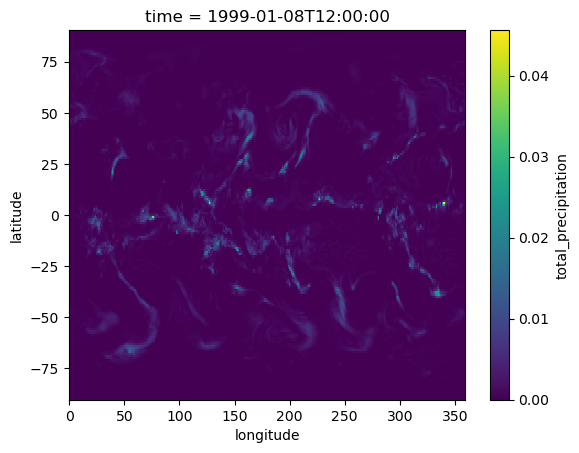

In [325]:
import xarray as xr
DS = xr.open_dataset('/glade/derecho/scratch/ksha/CREDIT_data/ERA5_plevel_1deg/all_in_one/ERA5_plevel_1deg_6h_1999_conserve.zarr')
DS['total_precipitation'].isel(time=30).plot()
plt.show()

In [98]:
import xarray as xr

/glade/work/wchapman/conda-envs/credit/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/glade/work/wchapman/conda-envs/credit/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


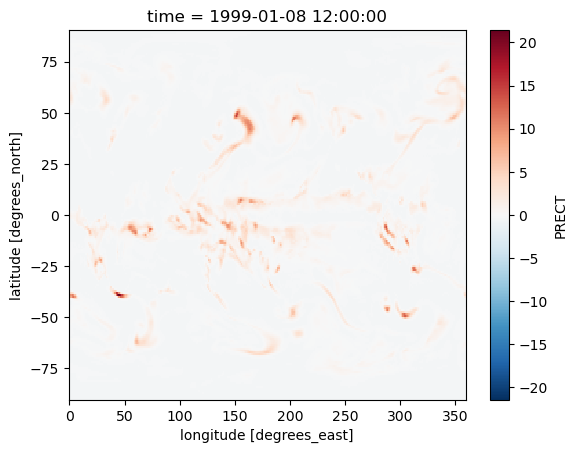

In [101]:
DScesm = xr.open_dataset('/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate_1999_ERA5scaled.zarr')
((DScesm['PRECT'].isel(time=30)-dsm['PRECT'].values)/dss['PRECT'].values).plot()
# (DScesm['PRECT']).isel(time=30).plot()
plt.show()

In [104]:
DScesm

<xarray.Dataset> Size: 164GB
Dimensions:    (time: 1460, latitude: 192, longitude: 288, level: 32, ilev: 33)
Coordinates:
  * ilev       (ilev) float64 264B 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * latitude   (latitude) float64 2kB -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * level      (level) float64 256B 3.643 7.595 14.36 ... 957.5 976.3 992.6
  * longitude  (longitude) float64 2kB 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
  * time       (time) object 12kB 1999-01-01 00:00:00 ... 1999-12-31 18:00:00
Data variables: (12/42)
    CLDHGH     (time, latitude, longitude) float64 646MB ...
    CLDLOW     (time, latitude, longitude) float64 646MB ...
    CLDMED     (time, latitude, longitude) float64 646MB ...
    CLDTOT     (time, latitude, longitude) float64 646MB ...
    FLDS       (time, latitude, longitude) float64 646MB ...
    FLNS       (time, latitude, longitude) float64 646MB ...
    ...         ...
    V          (time, level, latitude, longitude) float64 21GB ...
    ZMMU       (time, level, latitude, longitude) float64 21GB ...
    hyai       (time, ilev) float64 385kB ...
    hyam       (time, level) float64 374kB ...
    hybi       (time, ilev) float64 385kB ...
    hybm       (time, level) float64 374kB ...
Attributes:
    Conventions:       CF-1.0
    case:              f.e21.CREDIT_climate
    host:              derecho7
    initial_file:      f.e20.FHIST.f09_f09.cesm2_1.001_v2.cam.i.1979-01-01-00...
    logname:           wchapman
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    source:            CAM
    time_period_freq:  hour_6
    topography_file:   /glade/campaign/cesm/cesmdata/inputdata/atm/cam/topo/f...

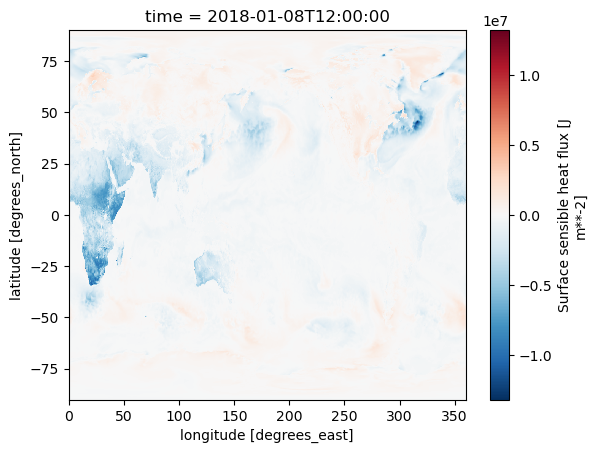

In [102]:
DSera5  = xr.open_zarr('/glade/derecho/scratch/ksha/CREDIT_data/ERA5_plevel_base/accum/ERA5_plevel_6h_accum_2018.zarr/')
DSera5['surface_sensible_heat_flux'].isel(time=30).plot()

In [103]:
DSera5

<xarray.Dataset> Size: 49GB
Dimensions:                        (time: 1460, latitude: 721, longitude: 1440)
Coordinates:
  * latitude                       (latitude) float32 3kB 90.0 89.75 ... -90.0
  * longitude                      (longitude) float32 6kB 0.0 0.25 ... 359.8
  * time                           (time) datetime64[ns] 12kB 2018-01-01 ... ...
Data variables:
    evaporation                    (time, latitude, longitude) float32 6GB dask.array<chunksize=(10, 721, 1440), meta=np.ndarray>
    surface_latent_heat_flux       (time, latitude, longitude) float32 6GB dask.array<chunksize=(10, 721, 1440), meta=np.ndarray>
    surface_net_solar_radiation    (time, latitude, longitude) float32 6GB dask.array<chunksize=(10, 721, 1440), meta=np.ndarray>
    surface_net_thermal_radiation  (time, latitude, longitude) float32 6GB dask.array<chunksize=(10, 721, 1440), meta=np.ndarray>
    surface_sensible_heat_flux     (time, latitude, longitude) float32 6GB dask.array<chunksize=(10, 721, 1440), meta=np.ndarray>
    top_net_solar_radiation        (time, latitude, longitude) float32 6GB dask.array<chunksize=(10, 721, 1440), meta=np.ndarray>
    top_net_thermal_radiation      (time, latitude, longitude) float32 6GB dask.array<chunksize=(10, 721, 1440), meta=np.ndarray>
    total_precipitation            (time, latitude, longitude) float32 6GB dask.array<chunksize=(10, 721, 1440), meta=np.ndarray>

In [96]:
dsm = xr.open_dataset('/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/mean_6h_1979_2010_32lev_1.0deg_ERA5scaled.nc')

In [28]:
dsm['PRECT'].values

array(0.00059708)

In [29]:
dss = xr.open_dataset('/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/std_6h_1979_2010_32lev_1.0deg_ERA5scaled.nc')

In [31]:
dss['PRECT'].values

array(0.0016165)

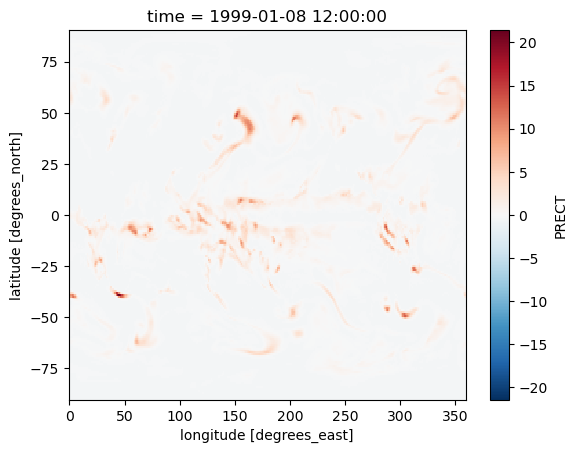

In [35]:
((DScesm['PRECT'].isel(time=30)-dsm['PRECT'].values)/dss['PRECT'].values).plot()

In [79]:
rm /glade/derecho/scratch/wchapman/CREDIT/cesm_wxformer/2010-01-05T00Z/*.nc

In [74]:
DSd=xr.open_dataset('/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate.statics_1.0deg_32levs_latlon_F32_hyai.nc')

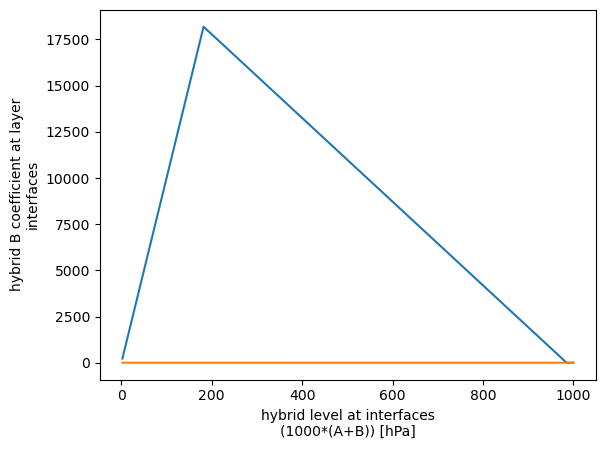

In [78]:
DSd['hyai'].plot()
DSd['hybi'].plot()

In [43]:
residual water:  tensor([          -10132499456.], device='cuda:0')
Precip SUM:  tensor([          25793261568.], device='cuda:0')
EVAP SUM:  tensor([          -16661121024.], device='cuda:0')
TWC sum: tensor([           1000358912.], device='cuda:0')

SyntaxError: invalid syntax (1063257191.py, line 1)

In [ ]:
10132499456
25793261568
16661121024
1000358912